# Project

In [1]:
import catboost as cb
from collections import Counter
# from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import mord
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import xgboost as xgb
# from statsmodels.graphics.regressionplots import plot_regress_exog

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
path = 'review-Alaska_10.json'

data_raw = pd.read_json(path, lines=True, encoding='utf-8')

invalid value encountered in cast


This indicates the presence of NA values in the data. However, as this is one of the aspects we intend to investigate, we will selectively perform data cleaning at a later stage.

In [3]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521515 entries, 0 to 521514
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  521515 non-null  float64
 1   name     521515 non-null  object 
 2   time     521515 non-null  int64  
 3   rating   521515 non-null  int64  
 4   text     298257 non-null  object 
 5   pics     20851 non-null   object 
 6   resp     44232 non-null   object 
 7   gmap_id  521515 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.8+ MB
None


In [4]:
print(data_raw.head())

        user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b6

## Data Dictionary

- index: The index of the data.
- user_id: The ID of the reviewer.
- name: The name of the reviewer.
- time: The time of the review in Unix time format.
- rating: The rating given by the reviewer for the business.
- text: The text of the review.
- pics: Pictures associated with the review.
- resp: The business response to the review, including Unix time and the text of the response.
- gmap_id: The ID of the business.

Due to the nature of our research topic, which is to explore the influence of time of day on online ratings across different devices, we will be selecting specific data variables for further analysis. The data variables of interest include "time," "rating," and "pics." The reason for selecting "pics" is due to the unfortunate inability to obtain data directly related to device types in the comments. Therefore, we need to make a crucial assumption: 
**we assume that comments with pictures are uploaded using mobile devices, while comments without pictures are uploaded using non-mobile devices.**

## Exploratory Data Analysis (EDA)



In this section, we will perform data preprocessing, which includes data cleaning and data transformation. Data cleaning involves handling missing values, outliers, and inconsistencies in the dataset. Data transformation may involve converting the "pics" data into device type data, etc. These steps allow us to make use of the available information and derive meaningful insights from the dataset. 

In [5]:
data_modified = (
    data_raw
    # Convert the timestamp to minutes since midnight
    .assign(minutes_since_midnight=lambda x: pd.to_datetime(x['time'], unit='ms', utc=True)
                                          .dt.tz_convert('America/Anchorage')
                                          .dt.hour * 60 
                                          + pd.to_datetime(x['time'], unit='ms', utc=True)
                                          .dt.tz_convert('America/Anchorage')
                                          .dt.minute)
    # device[0,1] represents ['Non-mobile devices', 'Mobile devices']
    .assign(device=lambda x: x['pics'].notnull().astype(int))
    # rating_binary[0,1] represents ['Rating not equal to 5', 'Rating equal to 5']
    .assign(rating_binary=lambda x: (x['rating'] == 5).astype(int))
    # length of text (words)
    .assign(text_length=lambda x: x['text'].apply(lambda t: len(t.split()) if t is not None else 0))
    # number of pics
    .assign(num_pics=lambda x: x['pics'].apply(lambda p: len(p) if isinstance(p, (list, pd.Series)) and p is not None else 0))
    # has_resp[0,1] represents ['No response', 'Has response']
    .assign(has_resp=lambda x: x['resp'].notnull().astype(int))
    .filter(['minutes_since_midnight', 'rating','rating_binary', 'device', 'text_length', 'num_pics', 'has_resp'])
)

print(data_modified[:10])


   minutes_since_midnight  rating  rating_binary  device  text_length  \
0                     732       5              1       0           30   
1                    1006       5              1       0           21   
2                    1031       4              0       0          137   
3                     922       4              0       0           61   
4                    1363       5              1       0           11   
5                     331       5              1       0           13   
6                    1167       5              1       1           22   
7                    1280       4              0       0           41   
8                    1196       2              0       0           25   
9                     728       3              0       0            3   

   num_pics  has_resp  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         0         0  
6         6         0  
7   

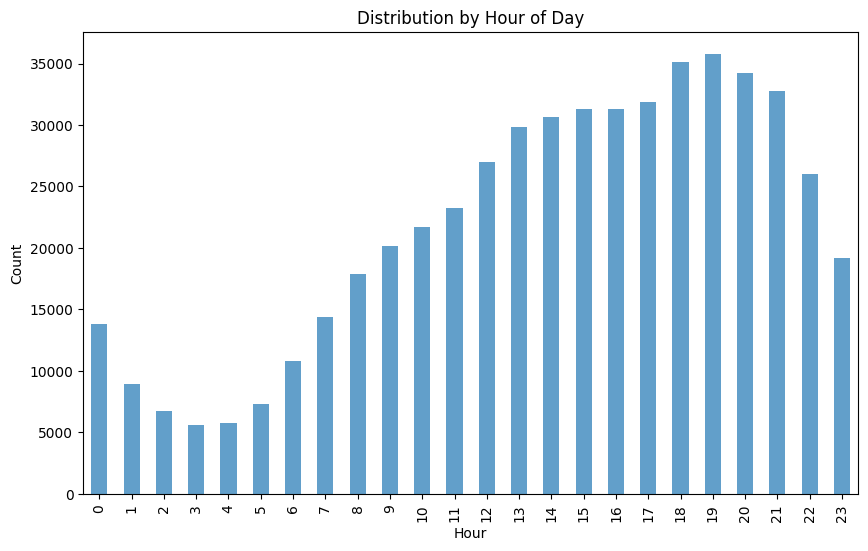

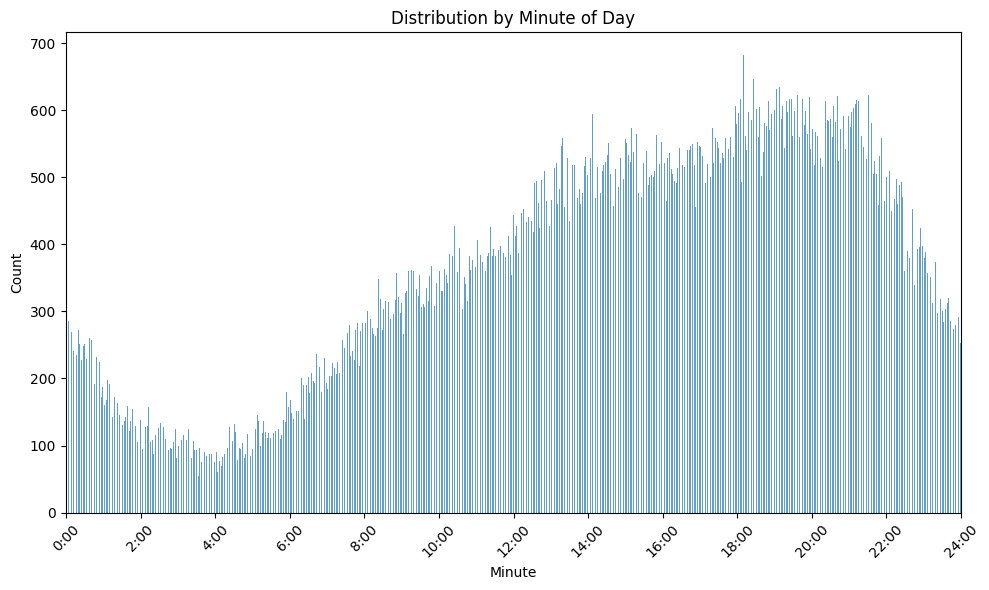

In [6]:
# Hourly distribution
plt.figure(figsize=(10,6))
(data_modified['minutes_since_midnight'] // 60).value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Distribution by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

# Minute-by-minute distribution
plt.figure(figsize=(10,6))
data_modified['minutes_since_midnight'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Distribution by Minute of Day')
plt.xlabel('Minute')
plt.ylabel('Count')

# Adjust x-axis ticks for better visibility
ticks = list(range(0, 1441, 120))  # Every 2 hours in minutes
labels = [f"{int(tick/60)}:{str(tick%60).zfill(2)}" for tick in ticks]  # Convert minute ticks to HH:MM format
plt.xticks(ticks, labels, rotation=45)
plt.tight_layout()
plt.show()


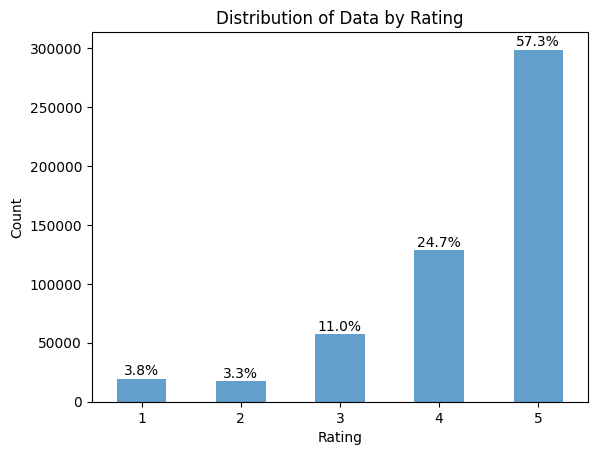

In [7]:
# Histogram for data distribution by rating
counts = data_modified['rating'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Data by Rating')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

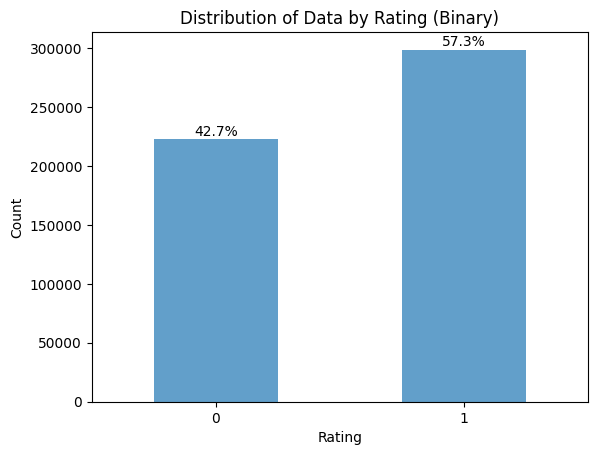

In [8]:
# Histogram for data distribution by rating
counts = data_modified['rating_binary'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Data by Rating (Binary)')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

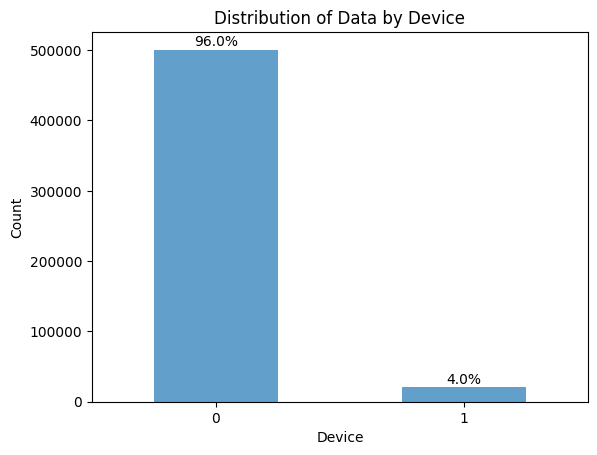

In [9]:
# Histogram for data distribution by devices
counts = data_modified['device'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Device')
plt.ylabel('Count')
plt.title('Distribution of Data by Device')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

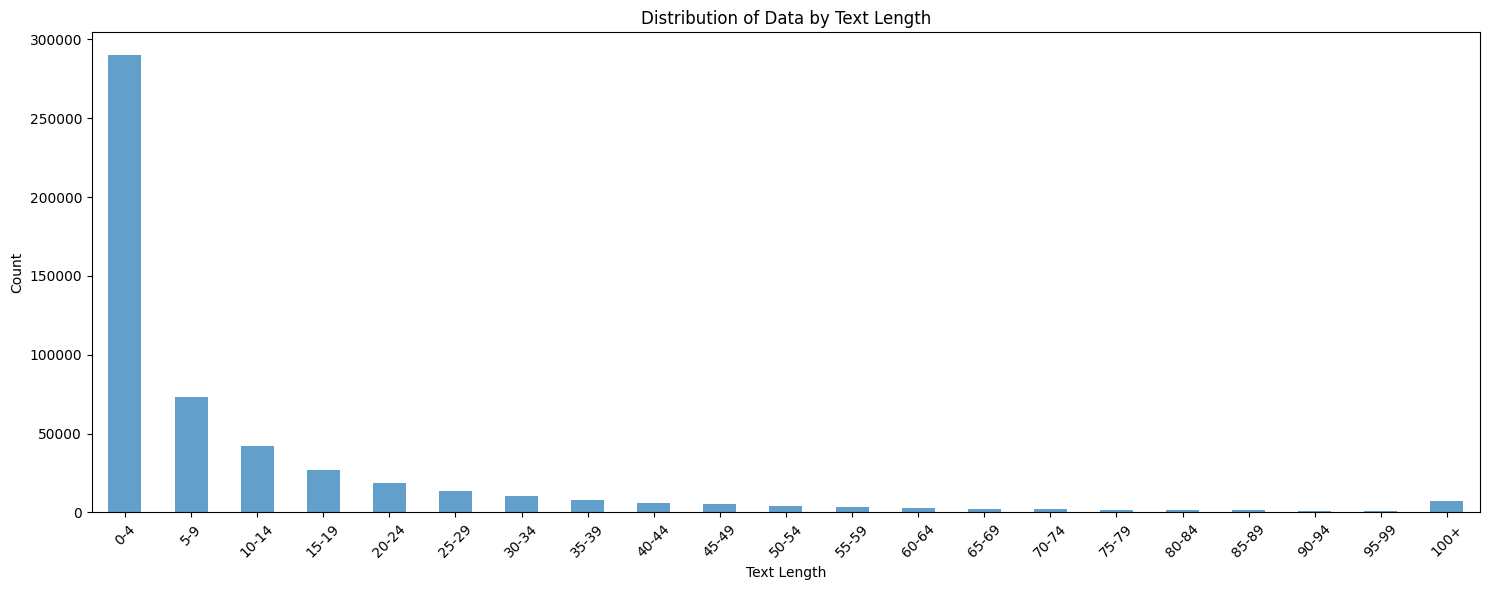

In [10]:
# Define the bin range for text_length
bins_text = list(range(0, 101, 5)) + [data_modified['text_length'].max() + 1]

# Labels for the bins
labels = [f"{bins_text[i]}-{bins_text[i+1]-1}" for i in range(len(bins_text)-2)] + ["100+"]

# Bin the text_length
data_modified['text_length_binned'] = pd.cut(data_modified['text_length'], bins=bins_text, right=False, labels=labels)

# Count the number of records in each bin
counts_text = data_modified['text_length_binned'].value_counts().sort_index()

# Plot
plt.figure(figsize=(15, 6))
counts_text.plot(kind='bar', alpha=0.7)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Distribution of Data by Text Length')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


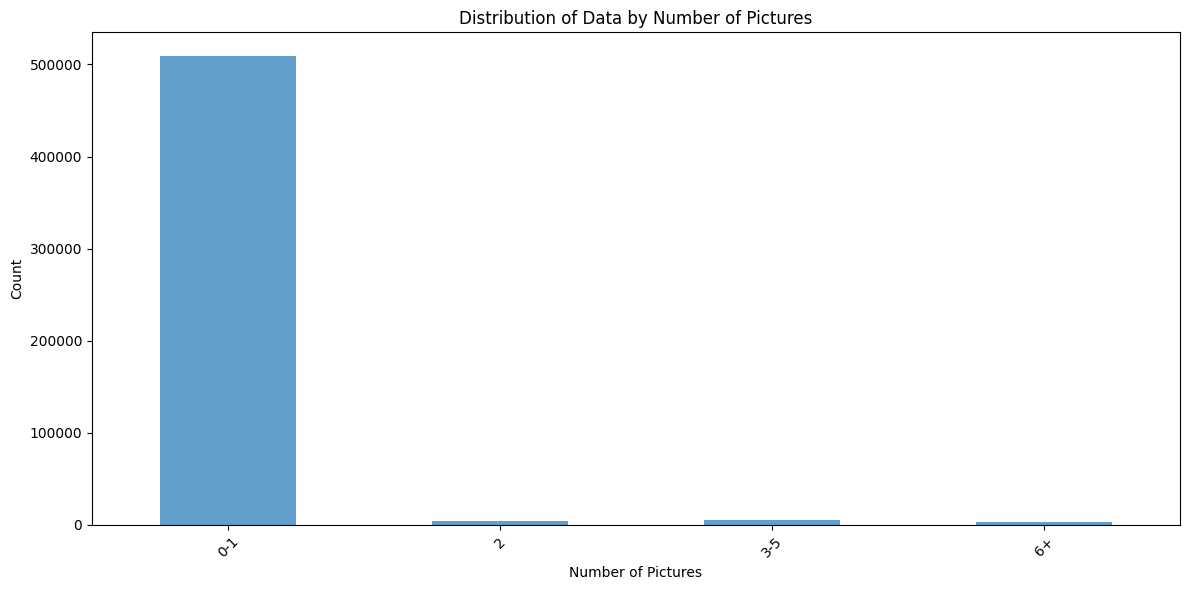

In [11]:
# Histogram for data distribution by num_pics
max_pics = 5  
data_modified['num_pics_binned'] = pd.cut(data_modified['num_pics'], bins=[-1, 1, 2, max_pics, data_modified['num_pics'].max()], labels=['0-1', '2', '3-'+str(max_pics), str(max_pics+1)+'+'])
counts_pics = data_modified['num_pics_binned'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
counts_pics.plot(kind='bar', alpha=0.7)
plt.xlabel('Number of Pictures')
plt.ylabel('Count')
plt.title('Distribution of Data by Number of Pictures')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

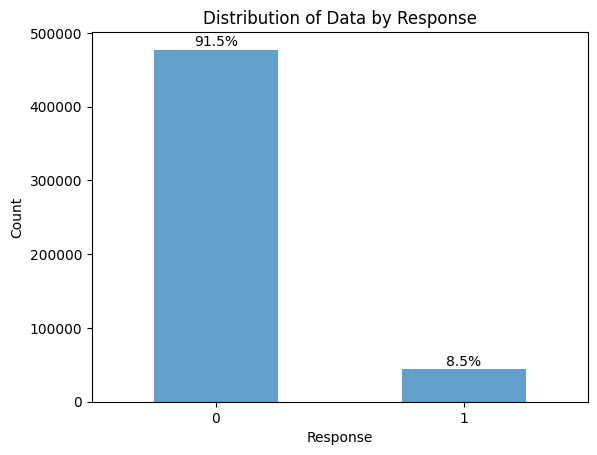

In [12]:
# Histogram for data distribution by has_resp
counts = data_modified['has_resp'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Data by Response')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

In [13]:
data_modified = data_modified.filter(['minutes_since_midnight', 'rating', 'rating_binary' , 'device', 'text_length', 'num_pics', 'has_resp']).dropna()
print(data_modified.isnull().sum())

minutes_since_midnight    0
rating                    0
rating_binary             0
device                    0
text_length               0
num_pics                  0
has_resp                  0
dtype: int64


### Chi-square

In [14]:
# Identify categorical variables
categorical_vars = ['device', 'rating', 'rating_binary', 'has_resp']

def detailed_chi2_pvalues(data, cat_vars):
    results = []
    for var1 in cat_vars:
        for var2 in cat_vars:
            if var1 != var2:
                chi2_stat, p_val, dof, expected = stats.chi2_contingency(pd.crosstab(data[var1], data[var2]))
                results.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Chi2 Statistic': chi2_stat,
                    'P-value': p_val,
                    'Degrees of Freedom': dof,
                    'Minimum Expected Frequency': expected.min()
                })
    return pd.DataFrame(results)

detailed_chi2_df = detailed_chi2_pvalues(data_modified, categorical_vars)
detailed_chi2_df


,Variable 1,Variable 2,Chi2 Statistic,P-value,Degrees of Freedom,Minimum Expected Frequency
0,device,rating,2611.388459,0.000000e+00,4,689.242666
1,device,rating_binary,2417.723639,0.000000e+00,1,8910.977301
2,device,has_resp,2.471260,1.159449e-01,1,1768.465781
3,rating,device,2611.388459,0.000000e+00,4,689.242666
4,rating,rating_binary,521515.000000,0.000000e+00,4,7367.336707
5,rating,has_resp,1189.394330,3.171964e-256,4,1462.116043
6,rating_binary,device,2417.723639,0.000000e+00,1,8910.977301
7,rating_binary,rating,521515.000000,0.000000e+00,4,7367.336707
8,rating_binary,has_resp,150.166893,1.593973e-34,1,18903.186800
9,has_resp,device,2.471260,1.159449e-01,1,1768.465781


### Spearman Correlation

In [15]:
# Identify continuous variables
continuous_vars = ['minutes_since_midnight', 'text_length', 'num_pics']

def detailed_spearman_correlation(data, cont_vars):
    results = []
    for var1 in cont_vars:
        for var2 in cont_vars:
            if var1 != var2:
                corr, p_val = stats.spearmanr(data[var1], data[var2])
                results.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Spearman Correlation': corr,
                    'P-value': p_val
                })
    return pd.DataFrame(results)

detailed_spearman_df = detailed_spearman_correlation(data_modified, continuous_vars)
detailed_spearman_df


,Variable 1,Variable 2,Spearman Correlation,P-value
0,minutes_since_midnight,text_length,-0.010145,2.364571e-13
1,minutes_since_midnight,num_pics,0.003389,1.439566e-02
2,text_length,minutes_since_midnight,-0.010145,2.364571e-13
3,text_length,num_pics,0.175291,0.000000e+00
4,num_pics,minutes_since_midnight,0.003389,1.439566e-02
5,num_pics,text_length,0.175291,0.000000e+00


### Multicollinearity test

In [16]:
X = data_modified[['minutes_since_midnight', 'rating', 'rating_binary', 'device', 'text_length', 'num_pics', 'has_resp']]
vif_data = pd.DataFrame()
vif_data['Features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nMulticollinearity test:")
print(vif_data)


Multicollinearity test:
                 Features        VIF
0  minutes_since_midnight   6.084309
1                  rating  11.632290
2           rating_binary   4.245394
3                  device   1.494129
4             text_length   1.223942
5                num_pics   1.432637
6                has_resp   1.096056


## Modeling

### Train and Test Sets

In [17]:
# Separate features (X) and target variable (y) in the balanced dataset
X = data_modified.drop(['rating', 'rating_binary'], axis=1)
y = data_modified['rating']

X_bi = data_modified.drop(['rating', 'rating_binary'], axis=1)
y_bi = data_modified['rating_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2221877)


In [18]:
# Split indices
train_idx, test_idx = train_test_split(data_modified.index, test_size=0.2, random_state=2221877)

# Use indices to extract training and testing data
X_train = data_modified.loc[train_idx].drop(['rating', 'rating_binary'], axis=1)
y_train = data_modified.loc[train_idx]['rating']

X_train_bi = data_modified.loc[train_idx].drop('rating', axis=1)
y_train_bi = data_modified.loc[train_idx]['rating_binary']

X_test = data_modified.loc[test_idx].drop(['rating', 'rating_binary'], axis=1)
y_test = data_modified.loc[test_idx]['rating']

X_test_bi = data_modified.loc[test_idx].drop('rating', axis=1)
y_test_bi = data_modified.loc[test_idx]['rating_binary']


### Data Balancing

It can be seen that there is a significant data imbalance between the different ratings. Having tried sampling and undersampling, I ended up combining them to try and get the most optimal sampling results to support my models.

In [19]:
# Calculate the number of samples in each class
counter = Counter(y)
counter_bi = Counter(y_bi)

# Define the target sample numbers for over-sampling and under-sampling
max_samples = max(counter.values())
min_samples = min(counter.values())
max_samples_bi = max(counter_bi.values())
min_samples_bi = min(counter_bi.values())

# Define pipeline
over = SMOTE(sampling_strategy={class_label: max_samples for class_label in counter})
under = RandomUnderSampler(sampling_strategy={class_label: min_samples for class_label in counter})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

over_bi = SMOTE(sampling_strategy={class_label: max_samples_bi for class_label in counter_bi})
under_bi = RandomUnderSampler(sampling_strategy={class_label: min_samples_bi for class_label in counter_bi})
steps_bi = [('o', over_bi), ('u', under_bi)]
pipeline_bi = Pipeline(steps=steps_bi)

# Apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X, y)
X_resampled_bi, y_resampled_bi = pipeline_bi.fit_resample(X_bi, y_bi)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=2221877)
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X_resampled_bi, y_resampled_bi, test_size=0.2, random_state=2221877)


Sample numbers before resampling: Counter({5: 298638, 4: 128640, 3: 57407, 1: 19591, 2: 17239})
Sample numbers after resampling: Counter({1: 17239, 2: 17239, 3: 17239, 4: 17239, 5: 17239})


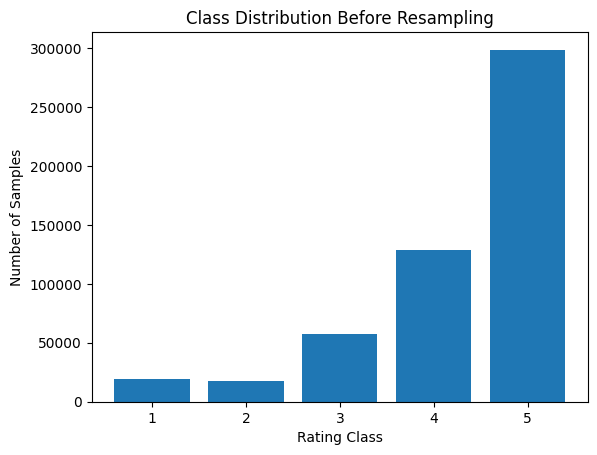

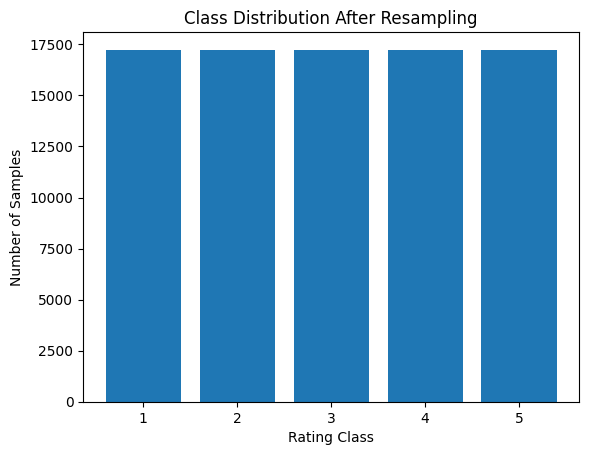

In [20]:
# Calculate the number of samples in each class before resampling
print("Sample numbers before resampling:", counter)

# Calculate the number of samples in each class after resampling
counter_after = Counter(y_resampled)
print("Sample numbers after resampling:", counter_after)

# Visualize class distribution before resampling
plt.bar(counter.keys(), counter.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before Resampling')
plt.show()

# Visualize class distribution after resampling
plt.bar(counter_after.keys(), counter_after.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Resampling')
plt.show()


Sample numbers before resampling: Counter({1: 298638, 0: 222877})
Sample numbers after resampling: Counter({0: 222877, 1: 222877})


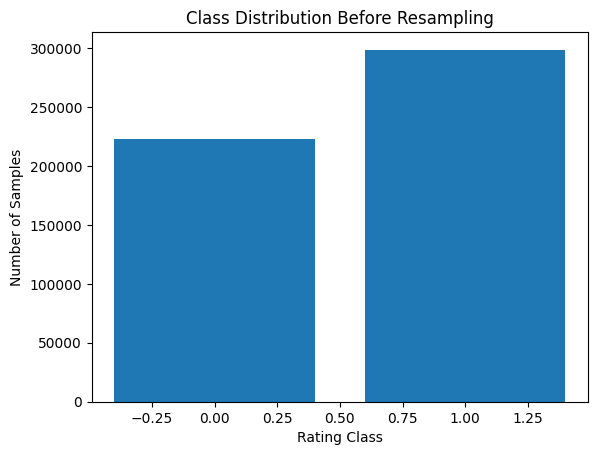

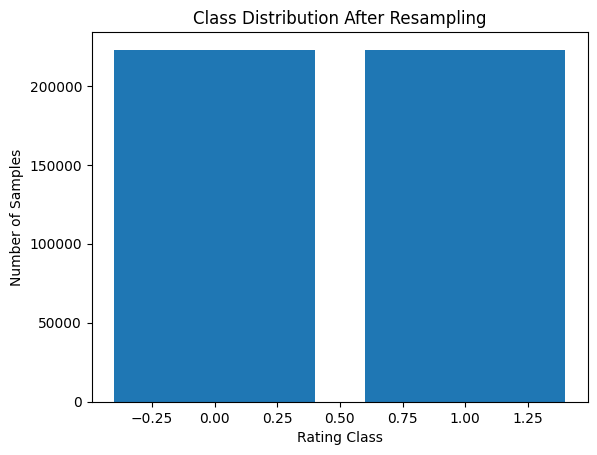

In [21]:
# Calculate the number of samples in each class before resampling
print("Sample numbers before resampling:", counter_bi)

# Calculate the number of samples in each class after resampling
counter_after_bi = Counter(y_resampled_bi)
print("Sample numbers after resampling:", counter_after_bi)

# Visualize class distribution before resampling
plt.bar(counter_bi.keys(), counter_bi.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before Resampling')
plt.show()

# Visualize class distribution after resampling
plt.bar(counter_after_bi.keys(), counter_after_bi.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Resampling')
plt.show()


### Decision Tree

Accuracy score:  0.643454739480671
              precision    recall  f1-score   support

           1       0.70      0.78      0.74      3408
           2       0.62      0.74      0.68      3443
           3       0.56      0.65      0.60      3446
           4       0.62      0.56      0.59      3503
           5       0.76      0.49      0.60      3439

    accuracy                           0.64     17239
   macro avg       0.65      0.64      0.64     17239
weighted avg       0.65      0.64      0.64     17239



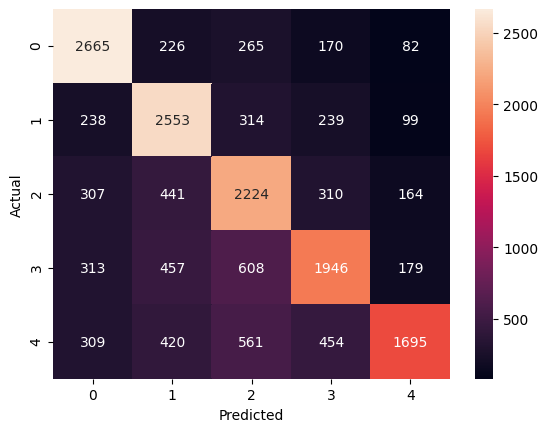

In [22]:
model_DT = DecisionTreeClassifier()

model_DT.fit(X_resampled, y_resampled)

predictions_DT = model_DT.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_DT))
print(classification_report(y_test, predictions_DT))

cm = confusion_matrix(y_test, predictions_DT)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

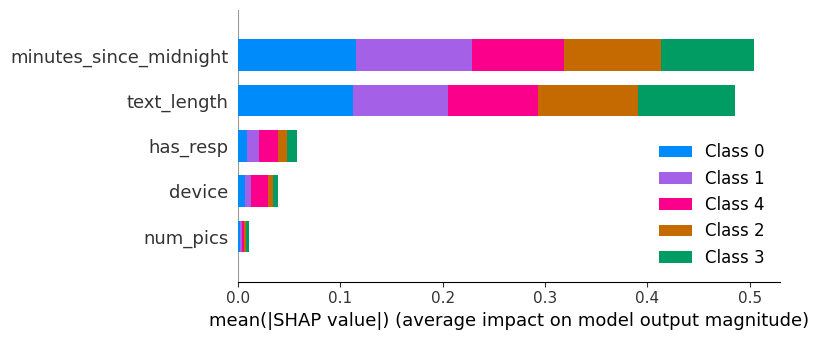

In [51]:
# Create an Explainer object
explainer_DT = shap.Explainer(model_DT)

# Calculate SHAP values
shap_values_DT = explainer_DT.shap_values(X_test)

# Visualise the first prediction's explanation
shap.summary_plot(shap_values_DT, X_test, plot_type="bar")

In [52]:
def plot_multiclass_summary(shap_values_list, X_test, class_names=None, max_display=None):
    num_classes = len(shap_values_list)
    
    if max_display is None:
        max_display = num_classes
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]
    
    for i in range(max_display):
        shap_values_class = shap_values_list[i]
        class_name = class_names[i]
        
        # Display summary plot for the class
        shap.summary_plot(shap_values_class, X_test, show=False, plot_type='dot', title=class_name)
        plt.title(class_name)
        plt.show()
        
        # Print average SHAP values for each feature for the class
        print(f"\nAverage SHAP values for {class_name}:\n")
        shap_avg = np.abs(shap_values_class).mean(axis=0)
        for feature, value in zip(X_test.columns, shap_avg):
            print(f"{feature}: {value:.4f}")
        print("\n" + "="*50 + "\n")

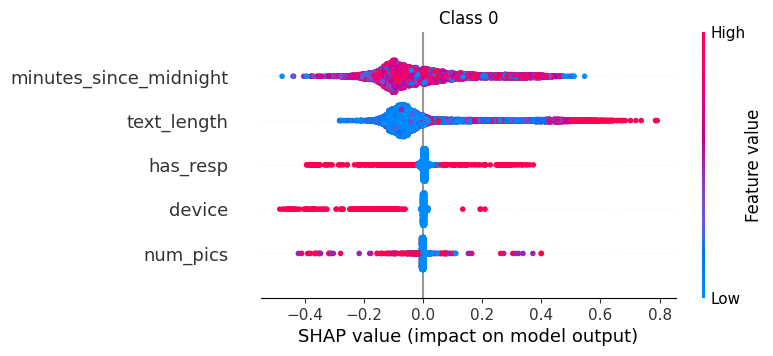


Average SHAP values for Class 0:

minutes_since_midnight: 0.1156
device: 0.0066
text_length: 0.1127
num_pics: 0.0023
has_resp: 0.0092




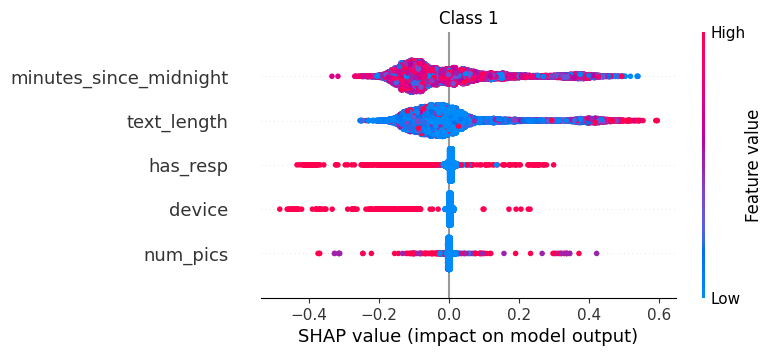


Average SHAP values for Class 1:

minutes_since_midnight: 0.1128
device: 0.0059
text_length: 0.0927
num_pics: 0.0018
has_resp: 0.0114




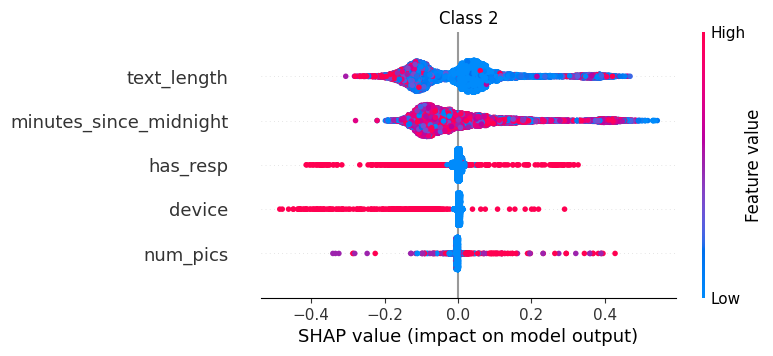


Average SHAP values for Class 2:

minutes_since_midnight: 0.0949
device: 0.0054
text_length: 0.0976
num_pics: 0.0020
has_resp: 0.0095




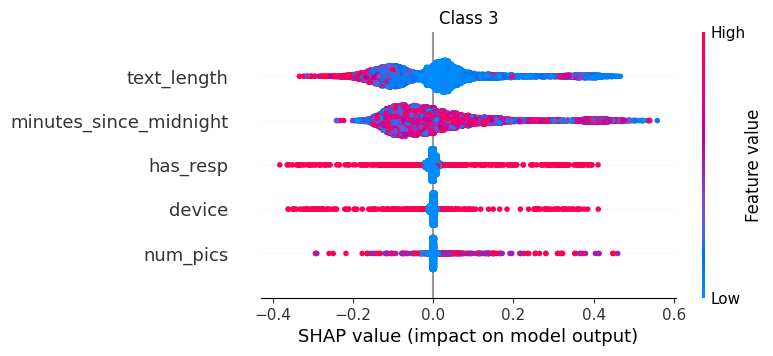


Average SHAP values for Class 3:

minutes_since_midnight: 0.0907
device: 0.0041
text_length: 0.0949
num_pics: 0.0026
has_resp: 0.0094




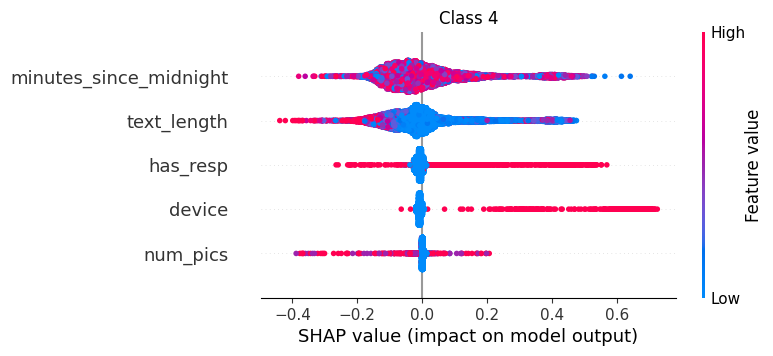


Average SHAP values for Class 4:

minutes_since_midnight: 0.0904
device: 0.0167
text_length: 0.0883
num_pics: 0.0022
has_resp: 0.0182




In [53]:
# Call the function with shap_values_DT and X_test
plot_multiclass_summary(shap_values_DT, X_test)

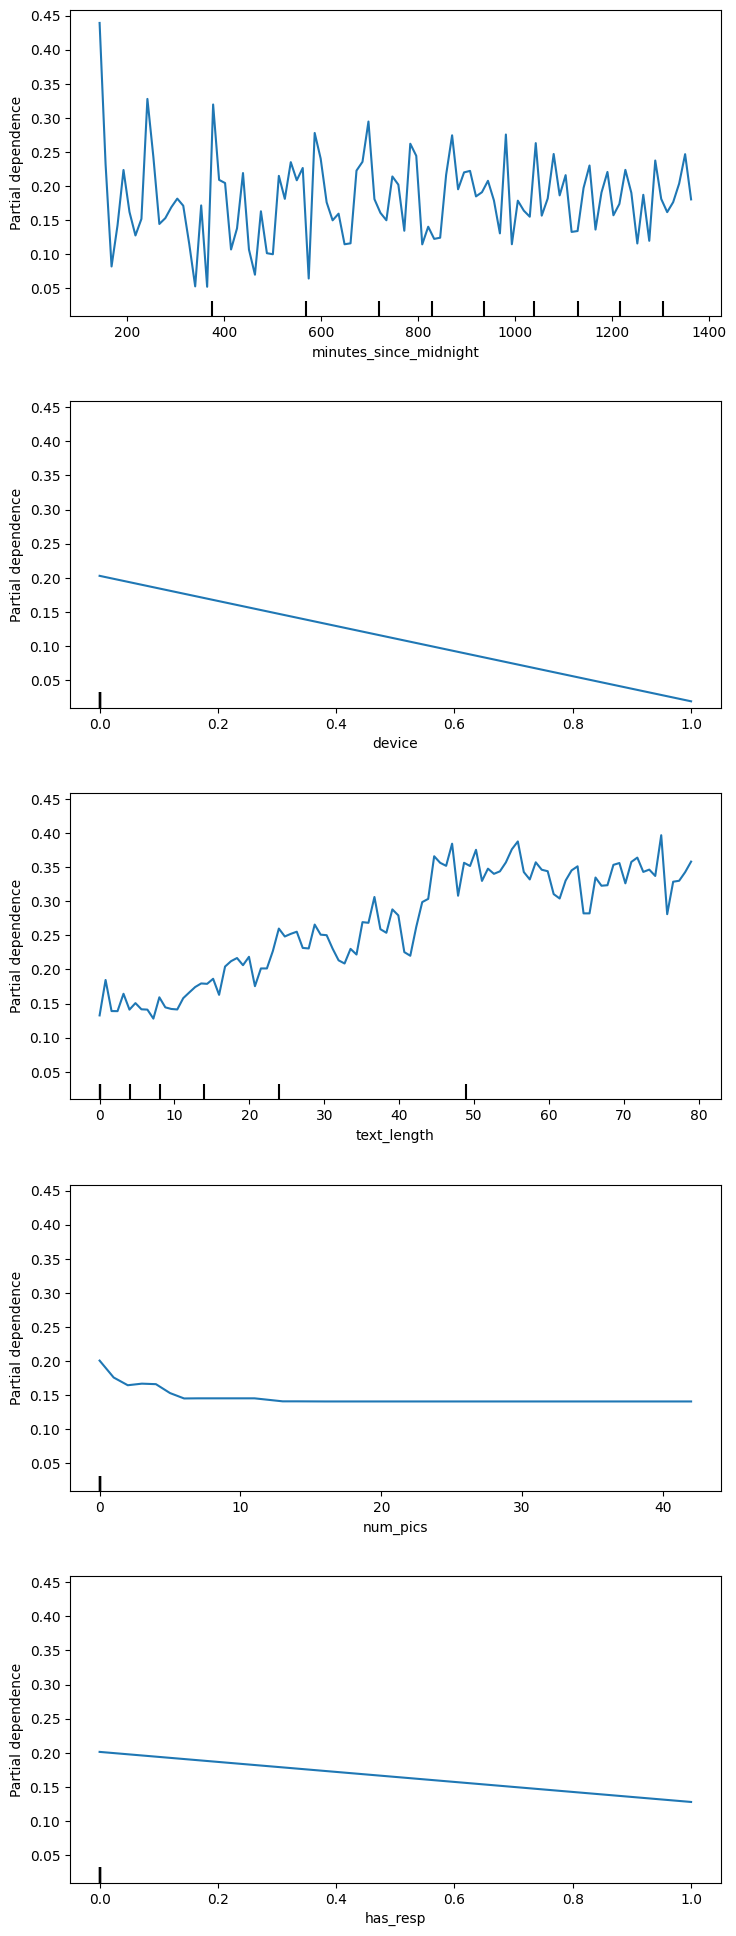

In [81]:
from sklearn.inspection import PartialDependenceDisplay

# Using the Decision Tree model as an example, and targeting class 1
features = ['minutes_since_midnight', 'device', 'text_length', 'num_pics', 'has_resp']

# Create a larger figure
fig, ax = plt.subplots(len(features), 1, figsize=(8, len(features) * 4))

display = PartialDependenceDisplay.from_estimator(model_DT, X_test, features, target=1, ax=ax)

# Adjust layout for better visibility
fig.tight_layout(pad=3.0)

# Display the plots
plt.show()



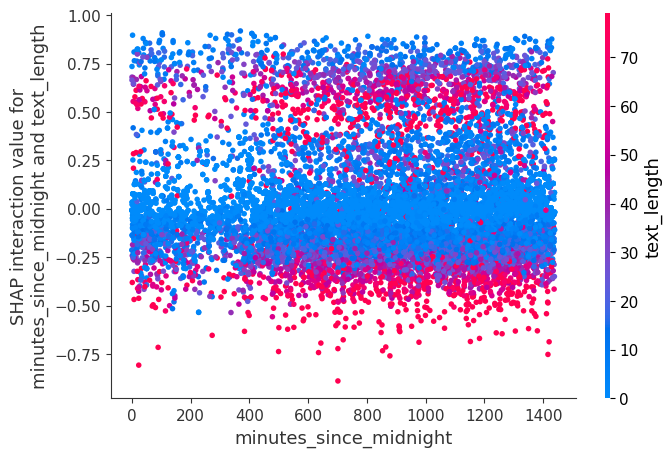

In [69]:
# Compute SHAP interaction values
shap_interaction_values = explainer_DT.shap_interaction_values(X_test)  # using a subset for visualization

# Just using the interaction values for the first class as an example
shap_values_class_0 = shap_interaction_values[0]

# Plot
shap.dependence_plot(
    ("minutes_since_midnight", "text_length"), 
    shap_values_class_0,
    X_test
)

TypeError: only size-1 arrays can be converted to Python scalars

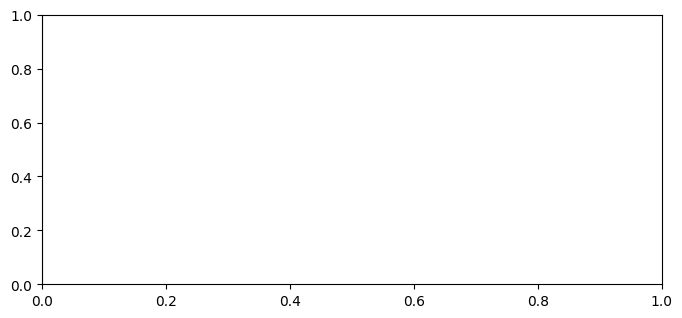

In [71]:
shap_interaction_values = explainer_DT.shap_interaction_values(X_test)

# Plotting interaction values for all features
shap.summary_plot(shap_interaction_values, X_test)


Accuracy score:  0.676756168635658
              precision    recall  f1-score   support

           0       0.64      0.79      0.71     44463
           1       0.73      0.57      0.64     44688

    accuracy                           0.68     89151
   macro avg       0.69      0.68      0.67     89151
weighted avg       0.69      0.68      0.67     89151



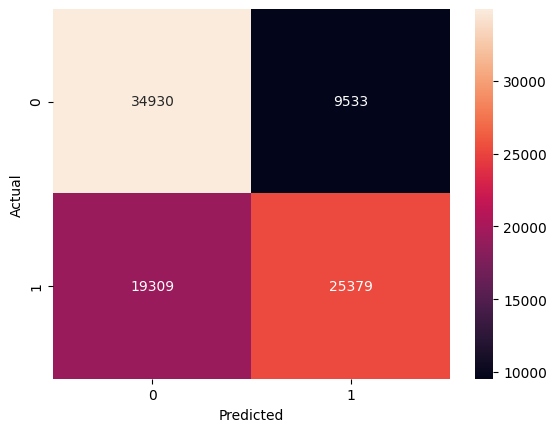

In [25]:
model_DT_bi = DecisionTreeClassifier()

model_DT_bi.fit(X_resampled_bi, y_resampled_bi)

predictions_DT_bi = model_DT_bi.predict(X_test_bi)

print('Accuracy score: ', balanced_accuracy_score(y_test_bi, predictions_DT_bi))
print(classification_report(y_test_bi, predictions_DT_bi))

cm_bi = confusion_matrix(y_test_bi, predictions_DT_bi)
sns.heatmap(cm_bi, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

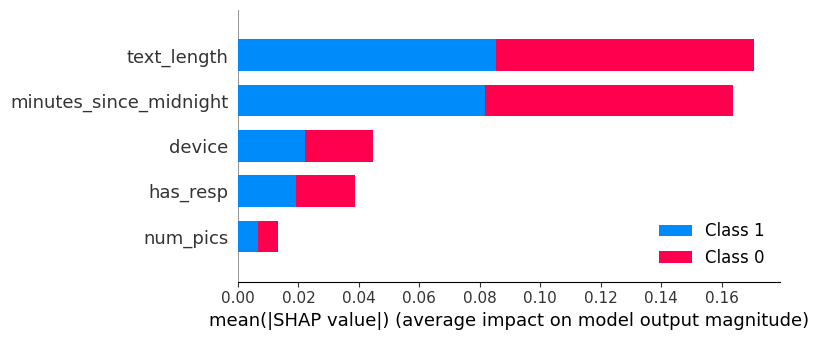

In [26]:
# Create an Explainer object
explainer_DT_bi = shap.Explainer(model_DT_bi)

# Calculate SHAP values
shap_values_DT_bi = explainer_DT_bi.shap_values(X_test_bi)

# Visualise the first prediction's explanation
shap.summary_plot(shap_values_DT_bi, X_test_bi)

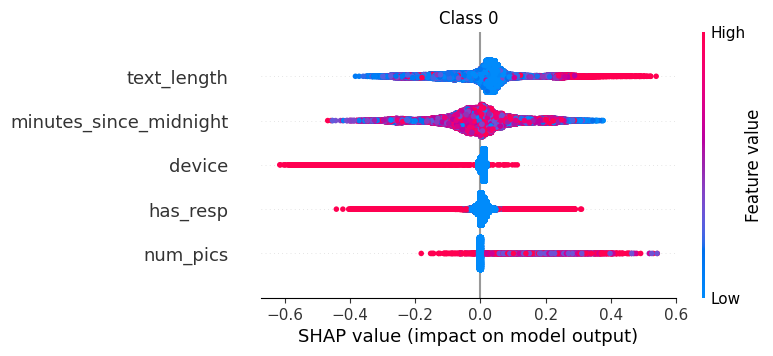


Average SHAP values for Class 0:

minutes_since_midnight: 0.0818
device: 0.0223
text_length: 0.0854
num_pics: 0.0067
has_resp: 0.0193




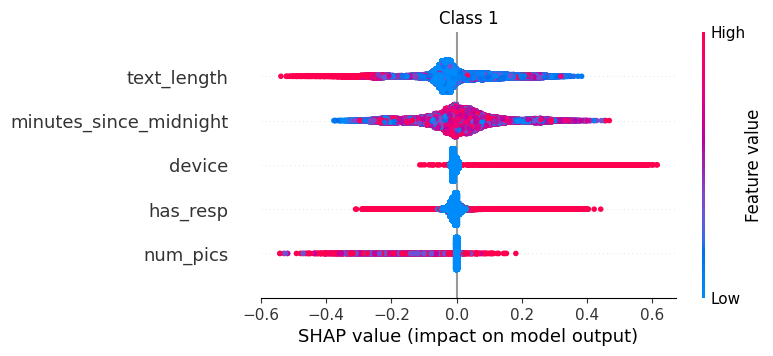


Average SHAP values for Class 1:

minutes_since_midnight: 0.0818
device: 0.0223
text_length: 0.0854
num_pics: 0.0067
has_resp: 0.0193




In [54]:
# Call the function with shap_values_DT_bi and X_test_bi
plot_multiclass_summary(shap_values_DT_bi, X_test_bi)

### Random Forest

Accuracy score:  0.6410835080679196
              precision    recall  f1-score   support

           1       0.74      0.72      0.73      3408
           2       0.65      0.70      0.67      3443
           3       0.56      0.64      0.60      3446
           4       0.59      0.59      0.59      3503
           5       0.69      0.57      0.62      3439

    accuracy                           0.64     17239
   macro avg       0.65      0.64      0.64     17239
weighted avg       0.64      0.64      0.64     17239



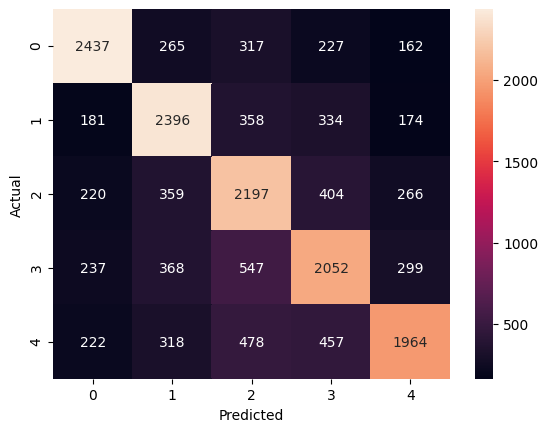

In [27]:
model_RF = RandomForestClassifier()

model_RF.fit(X_resampled, y_resampled)

predictions_RF = model_RF.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_RF))
print(classification_report(y_test, predictions_RF))

cm = confusion_matrix(y_test, predictions_RF)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy score:  0.6776938614500626
              precision    recall  f1-score   support

           0       0.65      0.75      0.70     44463
           1       0.71      0.61      0.65     44688

    accuracy                           0.68     89151
   macro avg       0.68      0.68      0.68     89151
weighted avg       0.68      0.68      0.68     89151



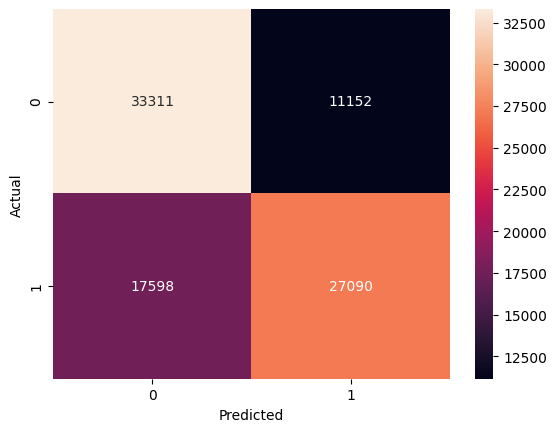

In [28]:
model_RF_bi = RandomForestClassifier()

model_RF_bi.fit(X_resampled_bi, y_resampled_bi)

predictions_RF_bi = model_RF_bi.predict(X_test_bi)

print('Accuracy score: ', balanced_accuracy_score(y_test_bi, predictions_RF_bi))
print(classification_report(y_test_bi, predictions_RF_bi))

cm_bi = confusion_matrix(y_test_bi, predictions_RF_bi)
sns.heatmap(cm_bi, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Ordinal Logistic Regression

Accuracy score:  0.24045015464414163
              precision    recall  f1-score   support

           1       0.53      0.07      0.13      3408
           2       0.28      0.13      0.18      3443
           3       0.22      0.90      0.35      3446
           4       0.26      0.04      0.08      3503
           5       0.71      0.06      0.10      3439

    accuracy                           0.24     17239
   macro avg       0.40      0.24      0.17     17239
weighted avg       0.40      0.24      0.17     17239



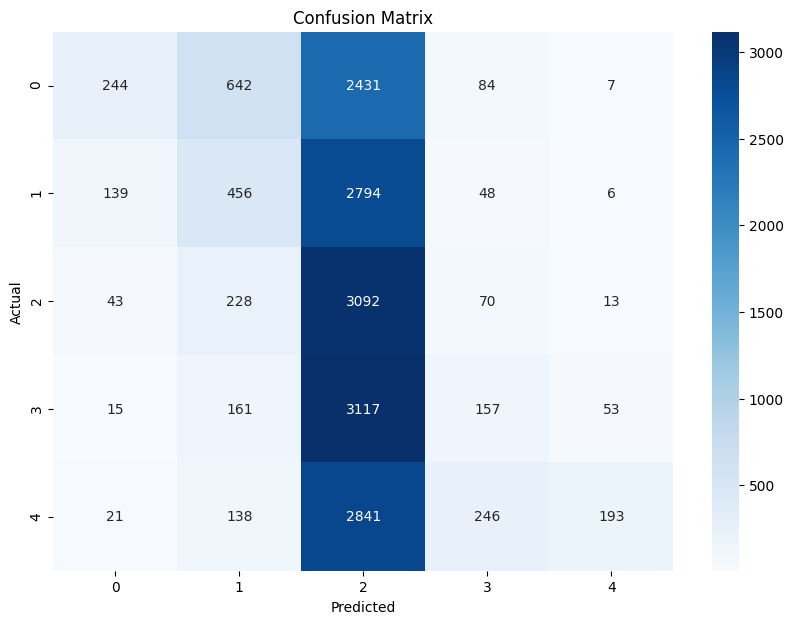

In [29]:
# Create an instance of the LogisticAT model
model_OL = mord.LogisticAT()

# Fit the model to the data
model_OL.fit(X_resampled, y_resampled)

# Use the model to make predictions
predictions_OL = model_OL.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_OL))
print(classification_report(y_test, predictions_OL))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions_OL)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Accuracy score:  0.5113277938066657
              precision    recall  f1-score   support

           0       0.51      0.69      0.58     44463
           1       0.52      0.34      0.41     44688

    accuracy                           0.51     89151
   macro avg       0.51      0.51      0.50     89151
weighted avg       0.51      0.51      0.50     89151



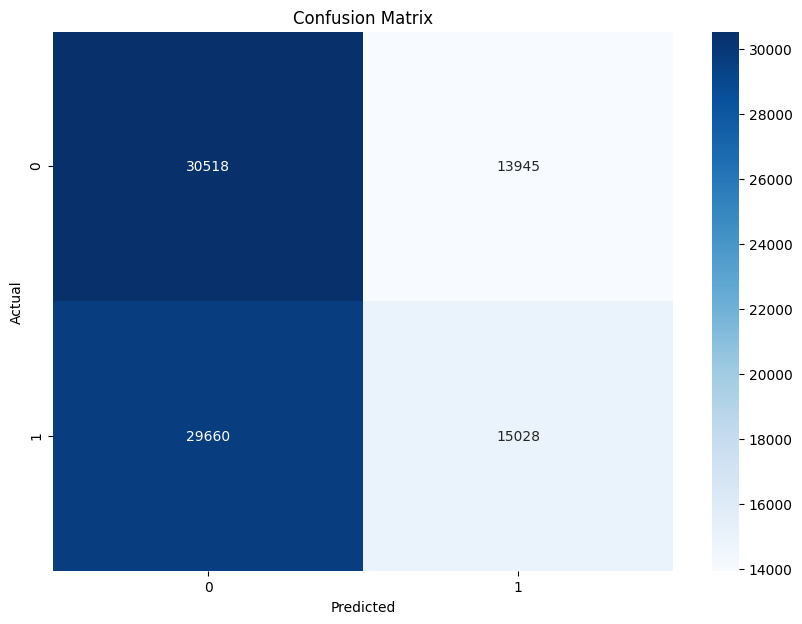

In [30]:
# Create an instance of the LogisticAT model
model_OL_bi = mord.LogisticAT()

# Fit the model to the data
model_OL_bi.fit(X_resampled_bi, y_resampled_bi)

# Use the model to make predictions
predictions_OL_bi = model_OL_bi.predict(X_test_bi)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test_bi, predictions_OL_bi))
print(classification_report(y_test_bi, predictions_OL_bi))

# Plot the confusion matrix
cm_bi = confusion_matrix(y_test_bi, predictions_OL_bi)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bi, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Gradient Boosting 

Accuracy score:  0.29247278885386063
              precision    recall  f1-score   support

           1       0.36      0.43      0.39      3408
           2       0.31      0.06      0.11      3443
           3       0.25      0.48      0.33      3446
           4       0.23      0.10      0.14      3503
           5       0.31      0.39      0.34      3439

    accuracy                           0.29     17239
   macro avg       0.29      0.29      0.26     17239
weighted avg       0.29      0.29      0.26     17239



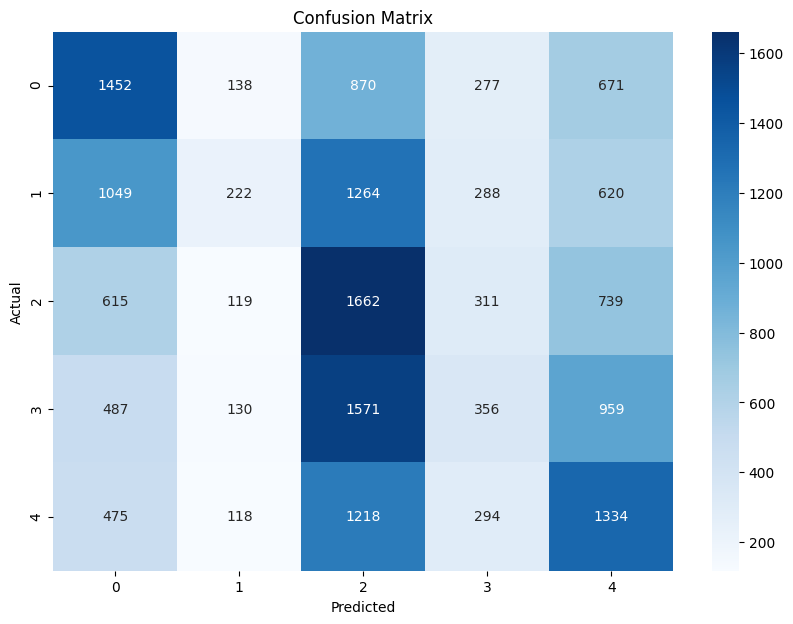

In [31]:
# Create a GradientBoostingClassifier
model_GB = GradientBoostingClassifier()

model_GB.fit(X_resampled, y_resampled)

predictions_GB = model_GB.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_GB))
print(classification_report(y_test, predictions_GB))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions_GB)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Accuracy score:  0.5545925507390944
              precision    recall  f1-score   support

           0       0.55      0.62      0.58     44463
           1       0.56      0.49      0.52     44688

    accuracy                           0.55     89151
   macro avg       0.56      0.55      0.55     89151
weighted avg       0.56      0.55      0.55     89151



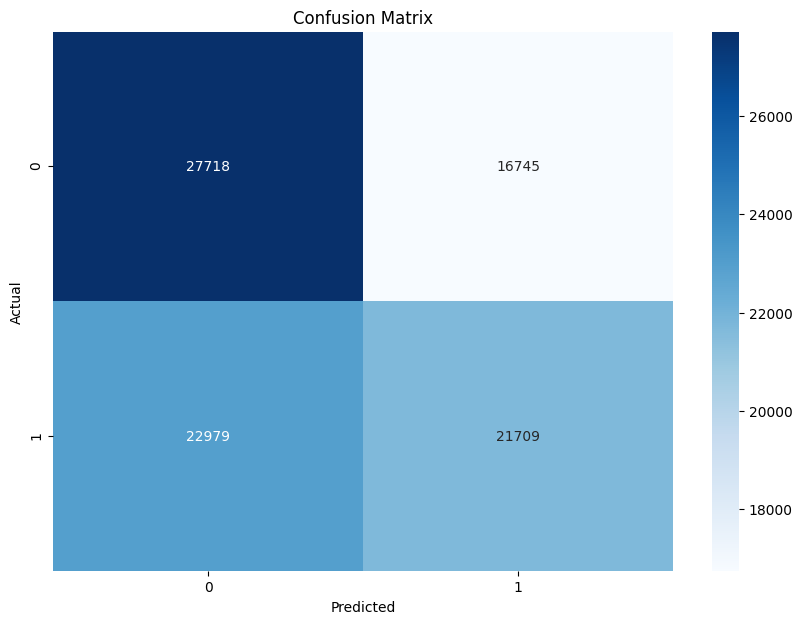

In [32]:
# Create a GradientBoostingClassifier
model_GB_bi = GradientBoostingClassifier()

model_GB_bi.fit(X_resampled_bi, y_resampled_bi)

predictions_GB_bi = model_GB_bi.predict(X_test_bi)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test_bi, predictions_GB_bi))
print(classification_report(y_test_bi, predictions_GB_bi))

# Plot the confusion matrix
cm_bi = confusion_matrix(y_test_bi, predictions_GB_bi)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bi, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### XGBoost

Accuracy score (XGBoost):  0.3652342731437631
              precision    recall  f1-score   support

           1       0.44      0.47      0.45      3408
           2       0.47      0.28      0.35      3443
           3       0.30      0.43      0.35      3446
           4       0.31      0.28      0.30      3503
           5       0.37      0.36      0.37      3439

    accuracy                           0.36     17239
   macro avg       0.38      0.37      0.36     17239
weighted avg       0.38      0.36      0.36     17239



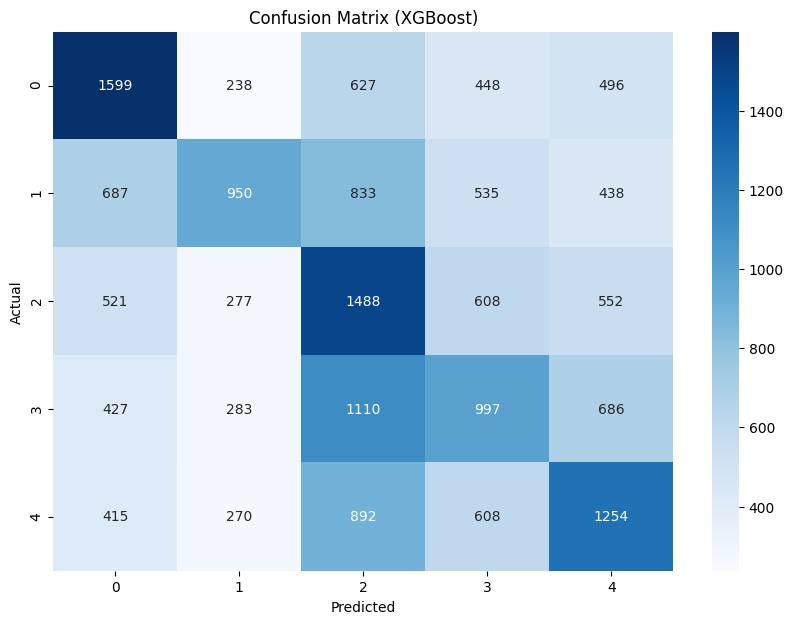

In [35]:
# Create an XGBoost classifier
model_XGB = xgb.XGBClassifier()

# Adjust labels for XGBoost
y_resampled_adjusted = y_resampled - 1
y_test_adjusted = y_test - 1

# Fit the model to the data
model_XGB.fit(X_resampled, y_resampled_adjusted)

# Make predictions
predictions_XGB = model_XGB.predict(X_test)

# Revert the predictions to the original scale
predictions_XGB = predictions_XGB + 1

# Evaluate the model's performance
print('Accuracy score (XGBoost): ', balanced_accuracy_score(y_test, predictions_XGB))
print(classification_report(y_test, predictions_XGB))

# Plot the confusion matrix
cm_XGB = confusion_matrix(y_test, predictions_XGB)
plt.figure(figsize=(10,7))
sns.heatmap(cm_XGB, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


device: 0.6171
has_resp: 0.1961
text_length: 0.0935
minutes_since_midnight: 0.0531
num_pics: 0.0402


<Figure size 1000x800 with 0 Axes>

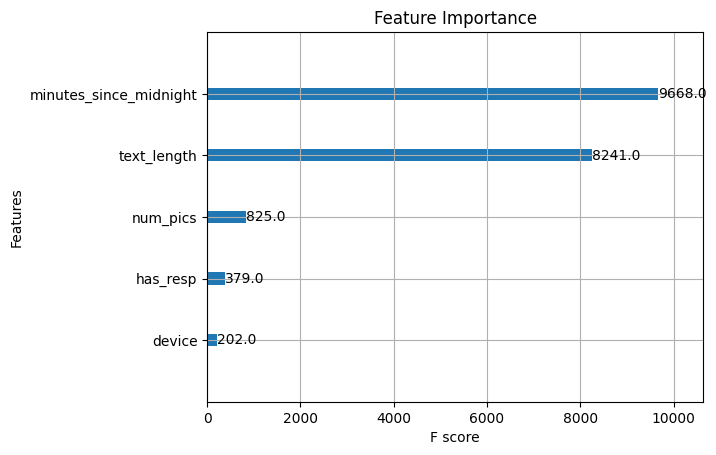

In [36]:
# Get feature importance
feature_importance = model_XGB.feature_importances_

# Create a mapping of feature names and their importance
feature_importance_dict = dict(zip(X.columns, feature_importance))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_XGB, importance_type='weight')
plt.title('Feature Importance')
plt.show()


Accuracy score (XGBoost):  0.5652148692441583
              precision    recall  f1-score   support

           0       0.56      0.64      0.59     44463
           1       0.58      0.49      0.53     44688

    accuracy                           0.57     89151
   macro avg       0.57      0.57      0.56     89151
weighted avg       0.57      0.57      0.56     89151



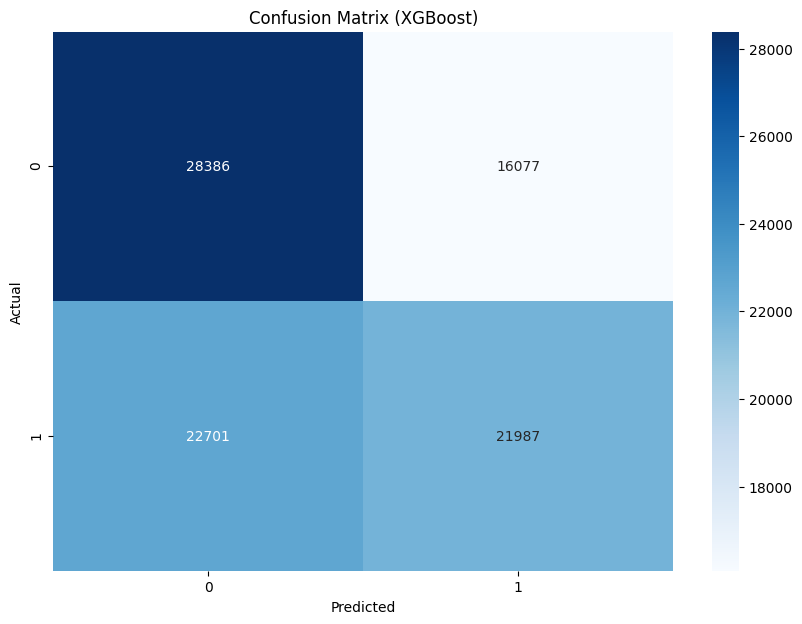

In [38]:
# Create an XGBoost classifier
model_XGB_bi = xgb.XGBClassifier()

# Fit the model to the data
model_XGB_bi.fit(X_resampled_bi, y_resampled_bi)

# Make predictions
predictions_XGB_bi = model_XGB_bi.predict(X_test_bi)

# Evaluate the model's performance
print('Accuracy score (XGBoost): ', balanced_accuracy_score(y_test_bi, predictions_XGB_bi))
print(classification_report(y_test_bi, predictions_XGB_bi))

# Plot the confusion matrix
cm_XGB_bi = confusion_matrix(y_test_bi, predictions_XGB_bi)
plt.figure(figsize=(10,7))
sns.heatmap(cm_XGB_bi, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


device: 0.7709
has_resp: 0.1017
text_length: 0.0612
num_pics: 0.0372
minutes_since_midnight: 0.0290


<Figure size 1000x800 with 0 Axes>

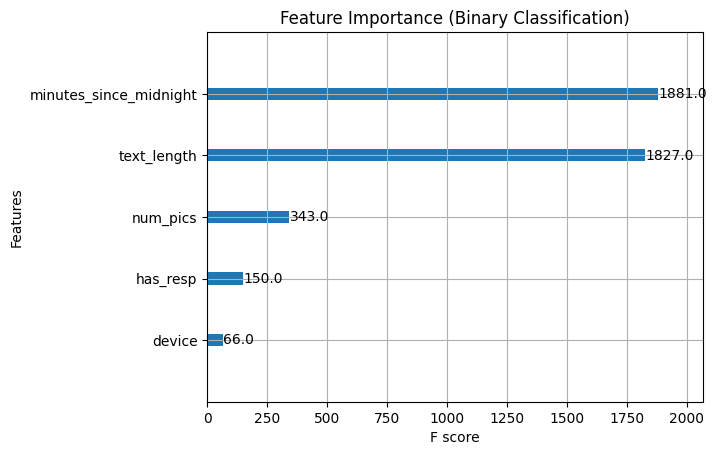

In [39]:
# Get feature importance for binary classification
feature_importance_bi = model_XGB_bi.feature_importances_

# Create a mapping of feature names and their importance for binary classification
feature_importance_dict_bi = dict(zip(X_resampled_bi.columns, feature_importance_bi))

# Sort by importance for binary classification
sorted_feature_importance_bi = sorted(feature_importance_dict_bi.items(), key=lambda x: x[1], reverse=True)

# Display sorted feature importance for binary classification
for feature, importance in sorted_feature_importance_bi:
    print(f"{feature}: {importance:.4f}")

# Visualize feature importance for binary classification
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_XGB_bi, importance_type='weight')
plt.title('Feature Importance (Binary Classification)')
plt.show()

### CatBoost

Accuracy score:  0.32255064812955253
              precision    recall  f1-score   support

           1       0.39      0.42      0.41      3408
           2       0.39      0.19      0.26      3443
           3       0.27      0.39      0.32      3446
           4       0.27      0.27      0.27      3503
           5       0.34      0.34      0.34      3439

    accuracy                           0.32     17239
   macro avg       0.33      0.32      0.32     17239
weighted avg       0.33      0.32      0.32     17239



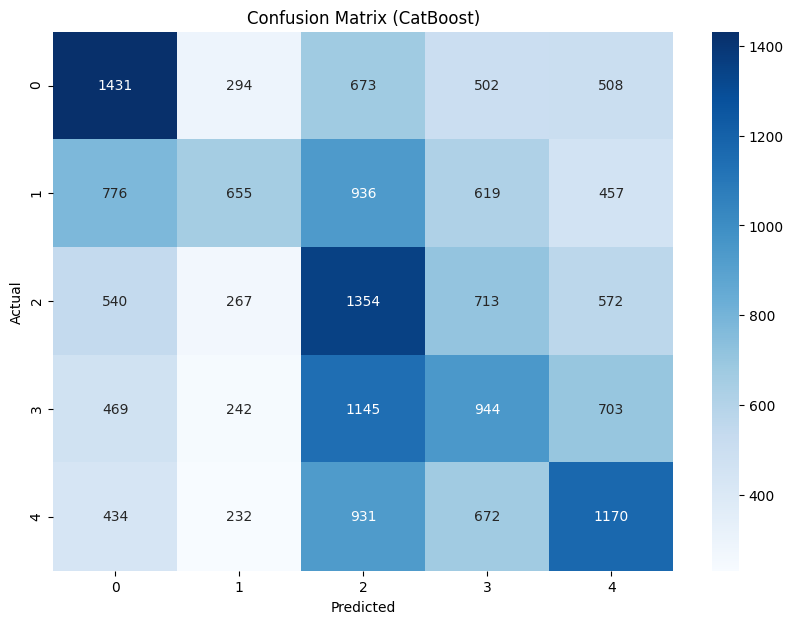

In [40]:
# Identify categorical features
cat_features = ['device', 'has_resp']

# Create a CatBoost classifier
model_CB = cb.CatBoostClassifier(cat_features=cat_features, verbose=0)

# Fit the model to the data
model_CB.fit(X_resampled, y_resampled)

# Make predictions
predictions_CB = model_CB.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_CB))
print(classification_report(y_test, predictions_CB))

# Plot the confusion matrix
cm_CB = confusion_matrix(y_test, predictions_CB)
plt.figure(figsize=(10,7))
sns.heatmap(cm_CB, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CatBoost)')
plt.show()


Accuracy score:  0.5622882333004864
              precision    recall  f1-score   support

           0       0.55      0.65      0.60     44463
           1       0.58      0.48      0.52     44688

    accuracy                           0.56     89151
   macro avg       0.56      0.56      0.56     89151
weighted avg       0.56      0.56      0.56     89151



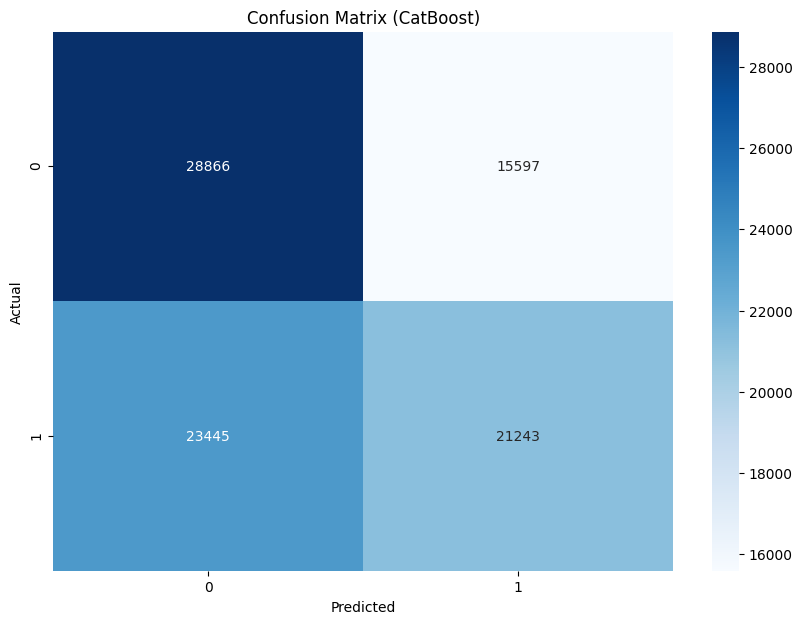

In [41]:
# Create a CatBoost classifier
model_CB_bi = cb.CatBoostClassifier(cat_features=cat_features, verbose=0)

# Fit the model to the data
model_CB_bi.fit(X_resampled_bi, y_resampled_bi)

# Make predictions
predictions_CB_bi = model_CB_bi.predict(X_test_bi)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test_bi, predictions_CB_bi))
print(classification_report(y_test_bi, predictions_CB_bi))

# Plot the confusion matrix
cm_CB_bi = confusion_matrix(y_test_bi, predictions_CB_bi)
plt.figure(figsize=(10,7))
sns.heatmap(cm_CB_bi, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CatBoost)')
plt.show()


### Model Comparisons


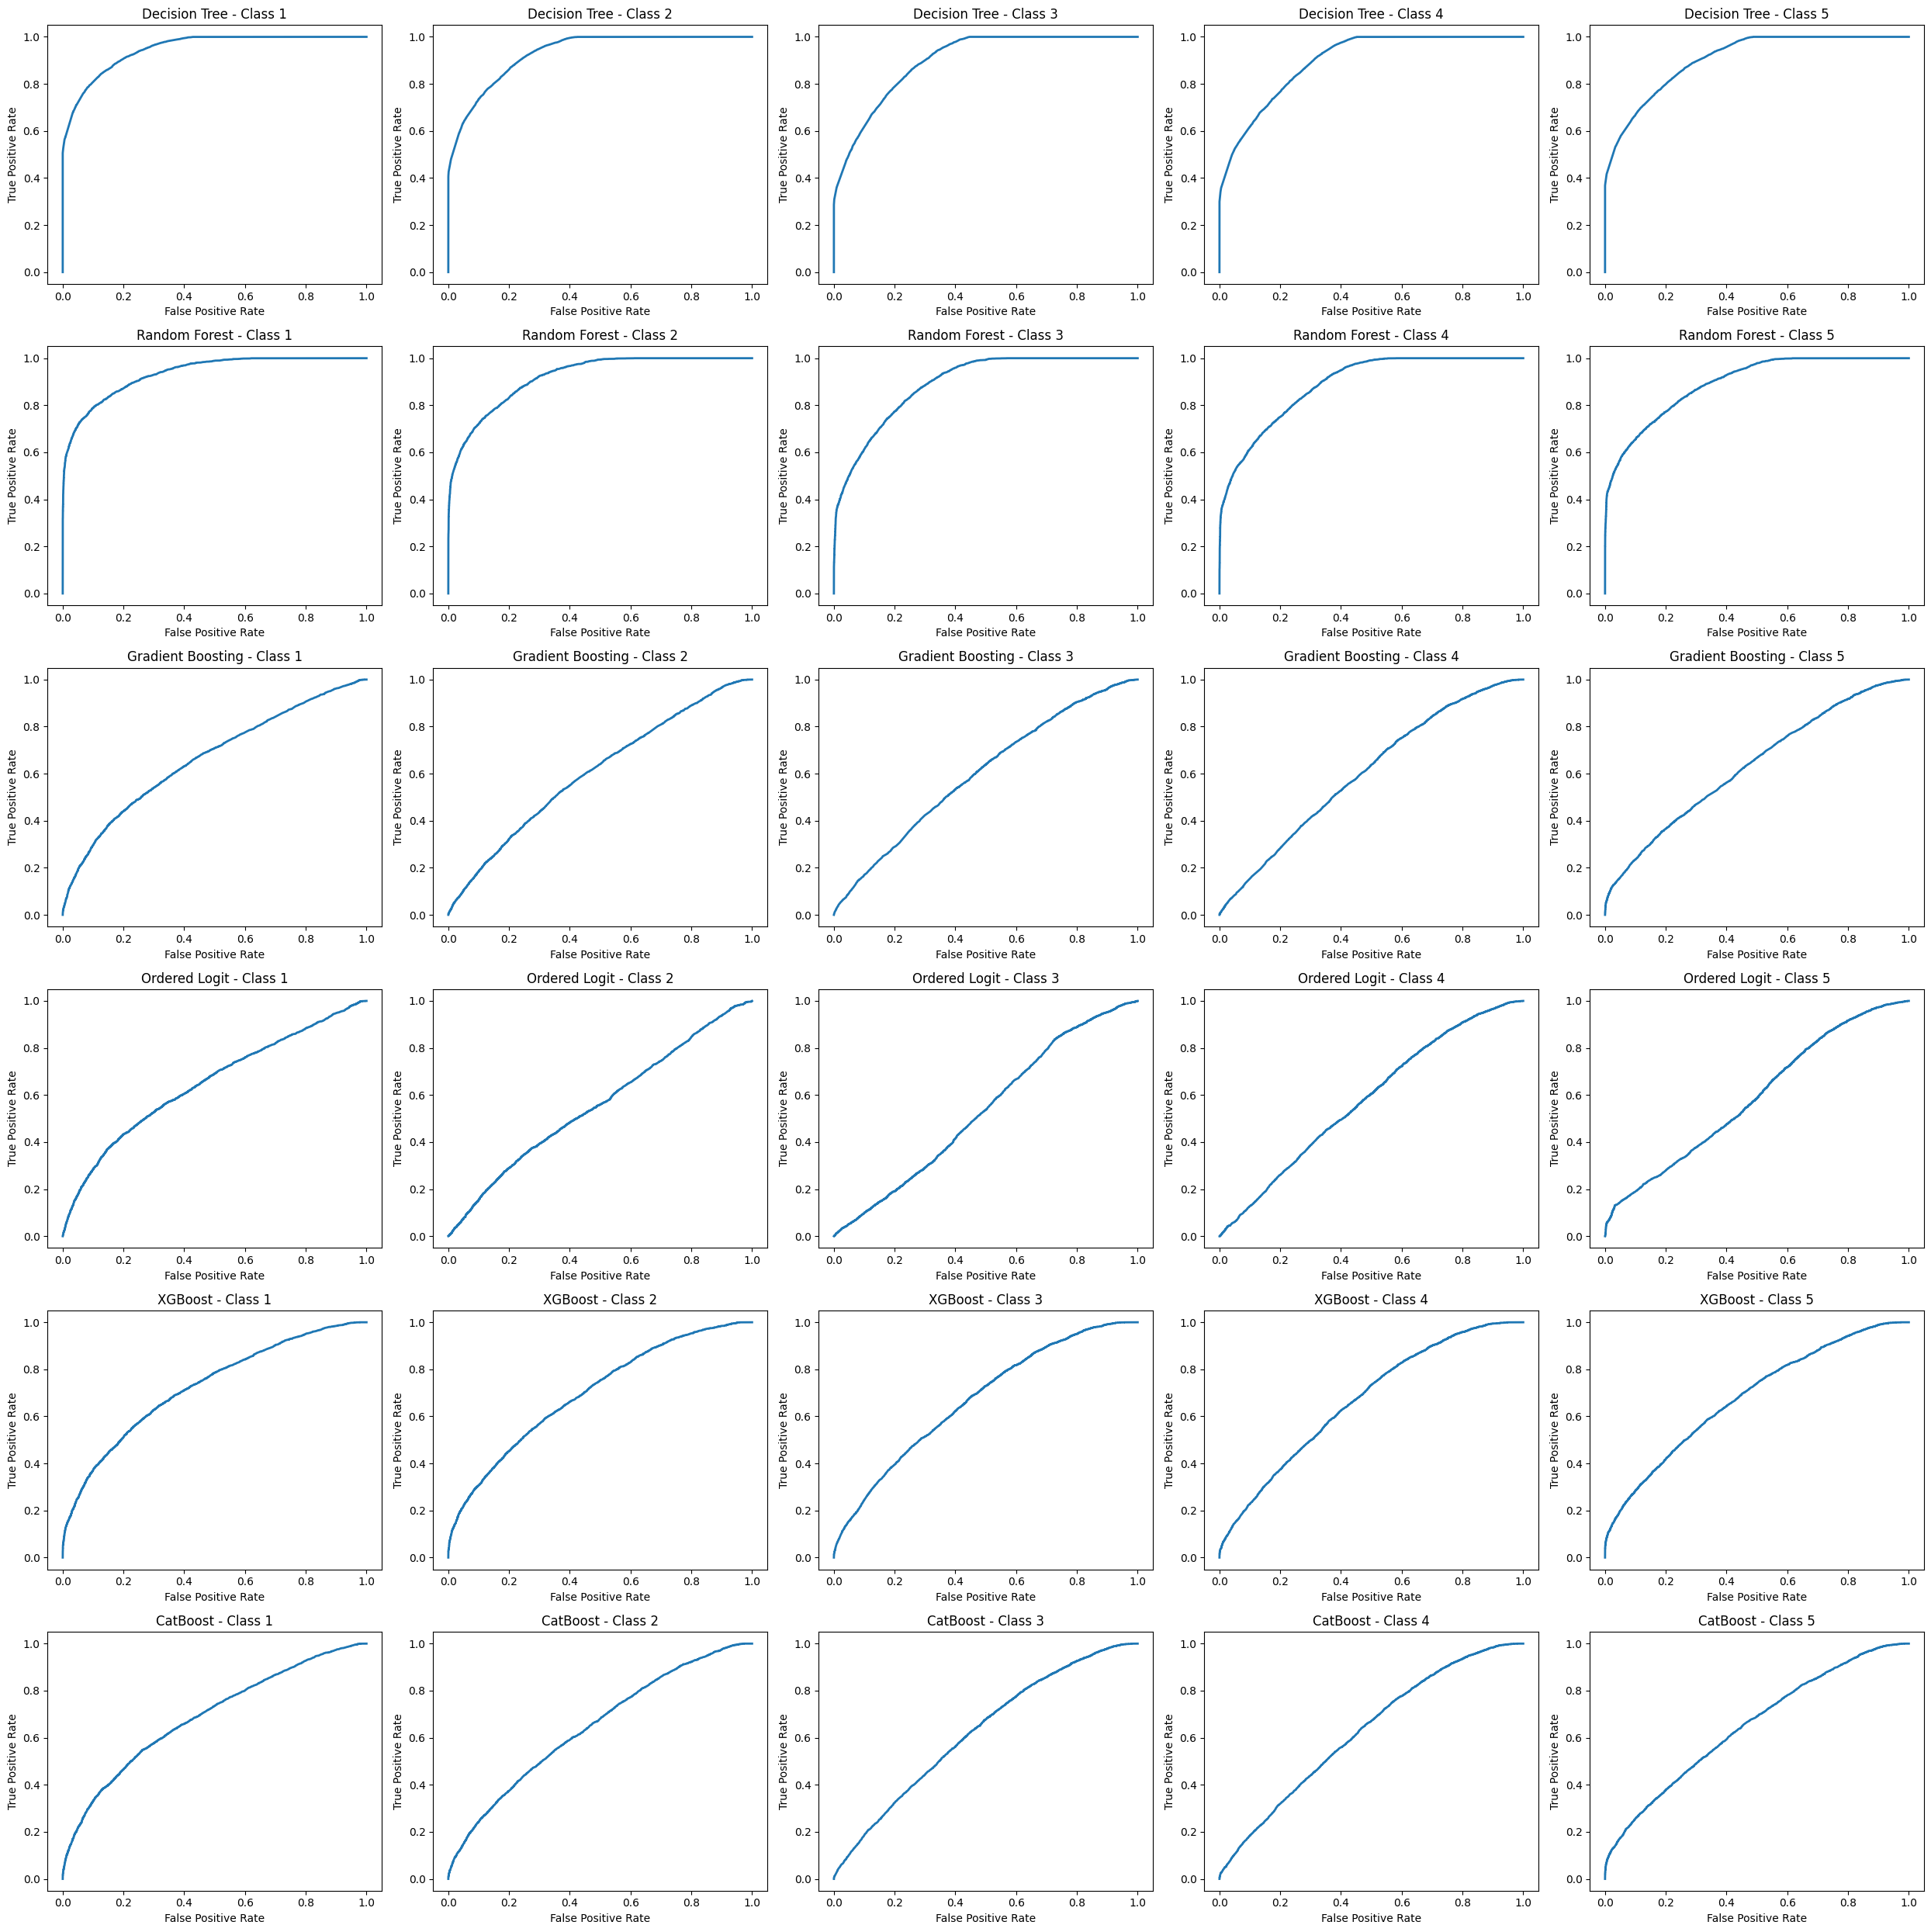

Decision Tree Overall Average AUC: 0.92
Random Forest Overall Average AUC: 0.91
Gradient Boosting Overall Average AUC: 0.62
Ordered Logit Overall Average AUC: 0.58
XGBoost Overall Average AUC: 0.69
CatBoost Overall Average AUC: 0.65


In [49]:
# Define a function to plot ROC curves for each class in a subplot
def plot_multiclass_roc_auc_subplot(ax, model, X_test, y_test, class_idx, model_name, lw=2):
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test == class_idx + 1, y_score[:, class_idx])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=lw)
    ax.set_title(f'{model_name} - Class {class_idx + 1}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return roc_auc

# Initialize subplots
fig, axes = plt.subplots(len(models), 5, figsize=(25, 25)) # Adjust figsize

auc_results = {}

# Loop through each model and plot ROC curves in subplots
models = [model_DT, model_RF, model_GB, model_OL, model_XGB, model_CB]
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Ordered Logit', 'XGBoost', 'CatBoost']

for idx, model in enumerate(models):
    avg_aucs = []
    for i, ax in enumerate(axes[idx]):
        auc_score = plot_multiclass_roc_auc_subplot(ax, model, X_test, y_test, i, model_names[idx])
        avg_aucs.append(auc_score)
    avg_auc = np.mean(avg_aucs)
    auc_results[model_names[idx]] = avg_auc

# Adjust layout
plt.tight_layout()
plt.show()

# Display overall average AUC results
for model_name, auc_score in auc_results.items():
    print(f"{model_name} Overall Average AUC: {auc_score:.2f}")


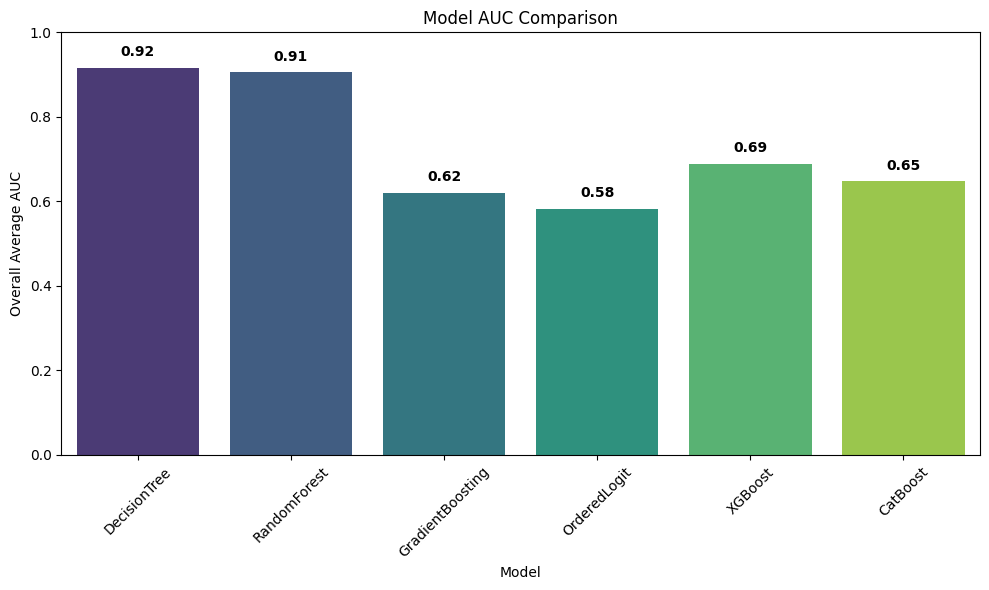

In [48]:
# Plot overall average AUC results
plt.figure(figsize=(10, 6))
model_names = list(auc_results.keys())
avg_aucs = list(auc_results.values())

# Create a bar plot for the AUC scores of each model
sns.barplot(x=model_names, y=avg_aucs, palette="viridis")
plt.xlabel('Model')
plt.ylabel('Overall Average AUC')
plt.title('Model AUC Comparison')
plt.ylim([0, 1])  # Set y-axis limits to [0, 1] for AUC
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the actual AUC values on top of each bar
for i, v in enumerate(avg_aucs):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')

plt.show()


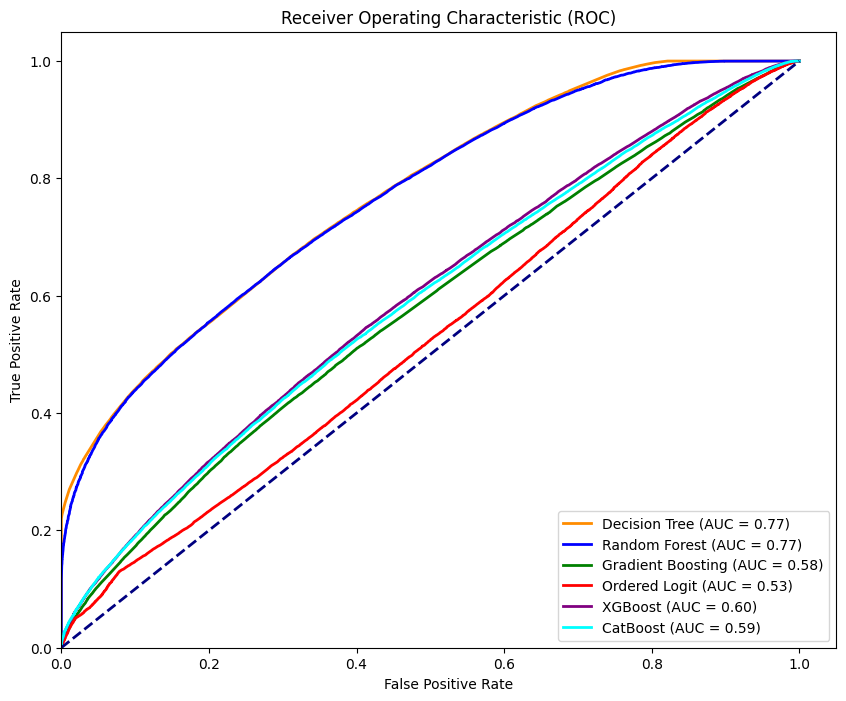

Decision Tree AUC: 0.771113393720823
Random Forest AUC: 0.7676025001606673
Gradient Boosting AUC: 0.577645305627865
Ordered Logit AUC: 0.5293909808095507
XGBoost AUC: 0.5965581701976965
CatBoost AUC: 0.5909587893570277


In [46]:
# Predict probabilities for all models
probs_DT = model_DT_bi.predict_proba(X_test_bi)[:, 1]
probs_RF = model_RF_bi.predict_proba(X_test_bi)[:, 1]
probs_GB = model_GB_bi.predict_proba(X_test_bi)[:, 1]
probs_OL = model_OL_bi.predict_proba(X_test_bi)[:, 1]
probs_XGB = model_XGB_bi.predict_proba(X_test_bi)[:, 1]
probs_CB = model_CB_bi.predict_proba(X_test_bi)[:, 1]

# Compute ROC curve and ROC area for each model
fpr_DT, tpr_DT, _ = roc_curve(y_test_bi, probs_DT)
roc_auc_DT = auc(fpr_DT, tpr_DT)

fpr_RF, tpr_RF, _ = roc_curve(y_test_bi, probs_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

fpr_GB, tpr_GB, _ = roc_curve(y_test_bi, probs_GB)
roc_auc_GB = auc(fpr_GB, tpr_GB)

fpr_OL, tpr_OL, _ = roc_curve(y_test_bi, probs_OL)
roc_auc_OL = auc(fpr_OL, tpr_OL)

fpr_XGB, tpr_XGB, _ = roc_curve(y_test_bi, probs_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

fpr_CB, tpr_CB, _ = roc_curve(y_test_bi, probs_CB)
roc_auc_CB = auc(fpr_CB, tpr_CB)

# Plot ROC curves in the same plot
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr_DT, tpr_DT, color='darkorange', lw=lw, label=f'Decision Tree (AUC = {roc_auc_DT:0.2f})')
plt.plot(fpr_RF, tpr_RF, color='blue', lw=lw, label=f'Random Forest (AUC = {roc_auc_RF:0.2f})')
plt.plot(fpr_GB, tpr_GB, color='green', lw=lw, label=f'Gradient Boosting (AUC = {roc_auc_GB:0.2f})')
plt.plot(fpr_OL, tpr_OL, color='red', lw=lw, label=f'Ordered Logit (AUC = {roc_auc_OL:0.2f})')
plt.plot(fpr_XGB, tpr_XGB, color='purple', lw=lw, label=f'XGBoost (AUC = {roc_auc_XGB:0.2f})')
plt.plot(fpr_CB, tpr_CB, color='cyan', lw=lw, label=f'CatBoost (AUC = {roc_auc_CB:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Optional: Print out AUC scores
print("Decision Tree AUC:", roc_auc_score(y_test_bi, probs_DT))
print("Random Forest AUC:", roc_auc_score(y_test_bi, probs_RF))
print("Gradient Boosting AUC:", roc_auc_score(y_test_bi, probs_GB))
print("Ordered Logit AUC:", roc_auc_score(y_test_bi, probs_OL))
print("XGBoost AUC:", roc_auc_score(y_test_bi, probs_XGB))
print("CatBoost AUC:", roc_auc_score(y_test_bi, probs_CB))
